In [38]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

import pandas as pd
import numpy as np
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Import CSV for TTVFast simulations
df = pd.read_csv(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME\validation\1st_order_TTVFast\lithwick_TTVFast_params.csv")
df = df[(df.valid == True) & (df.j == 3)]
df.head()

,e1,w1,e2,w2,Delta,j,P1,P2,m1,m2,mu1,mu2,validity1,validity2,valid
3,0.016555,8.010640,0.034746,50.908861,0.082842,3,7,11.369840,1.647885,3.817003,0.000005,0.000011,83758.155781,17228.363158,True
18,0.065756,82.884789,0.016307,3.628461,0.031656,3,7,10.832389,0.376612,9.053347,0.000001,0.000027,13472.746447,2259.935648,True
30,0.001597,6.225772,0.002158,50.984720,0.055422,3,7,11.081930,798.730506,4.434133,0.002399,0.000013,801.828836,106884.962290,True
37,0.006117,16.515020,0.001138,66.984457,-0.051133,3,7,9.963103,4.800577,2393.314475,0.000014,0.007188,29643.748785,319.740364,True
41,0.015708,76.107755,0.012114,24.132356,-0.032491,3,7,10.158848,7.032732,36.937576,0.000021,0.000111,3181.671910,785.474318,True


Expected PTTV | validity1 | validity2
45.74916446277032 d | 83758.15578136896 | 17228.363158280776


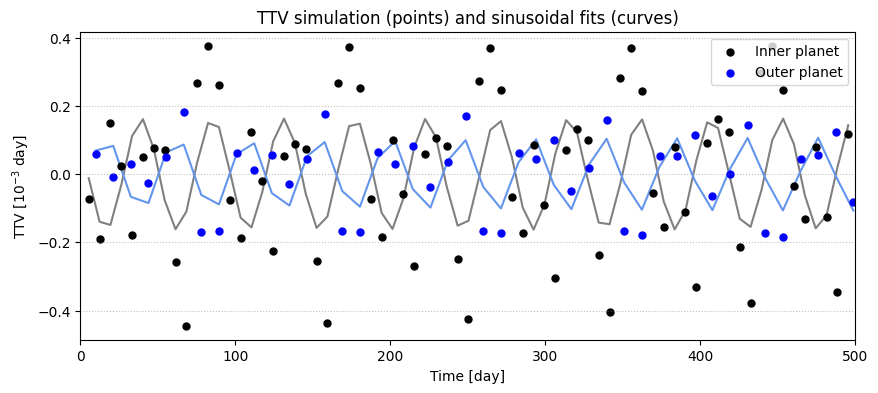

Expected PTTV | validity1 | validity2
114.06331565867441 d | 13472.746447444615 | 2259.93564829531


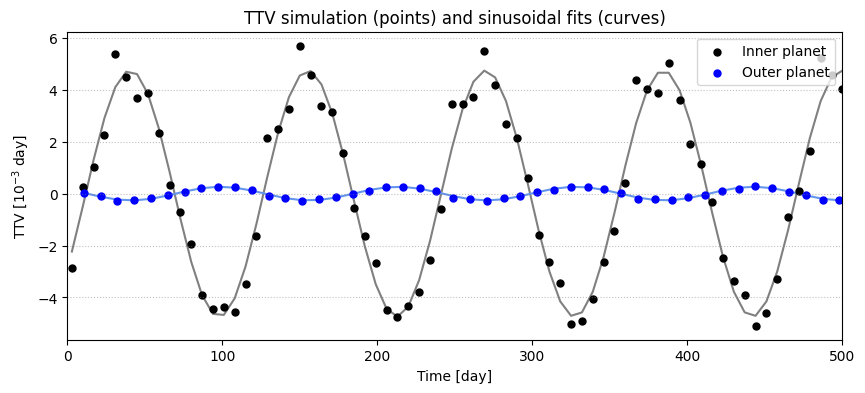

Expected PTTV | validity1 | validity2
66.65188784735885 d | 801.8288358072106 | 106884.96228976813


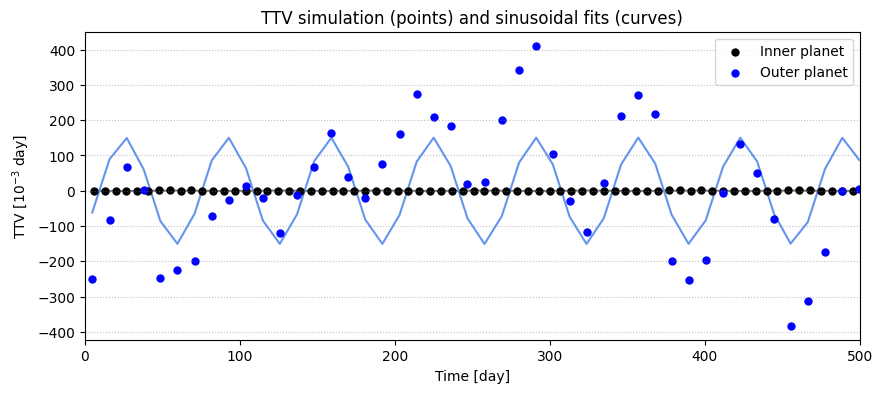

Expected PTTV | validity1 | validity2
104.22330232488683 d | 3181.671910065665 | 785.4743184388083


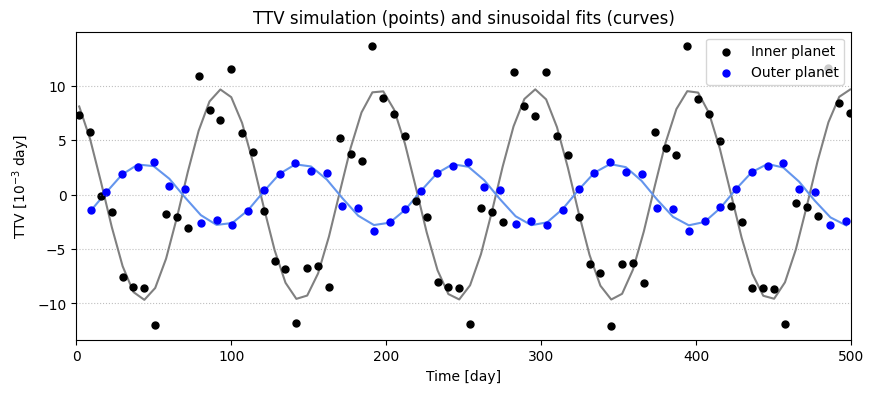

Expected PTTV | validity1 | validity2
103.36096956020239 d | 28350.818728404654 | 2067.7923667340065


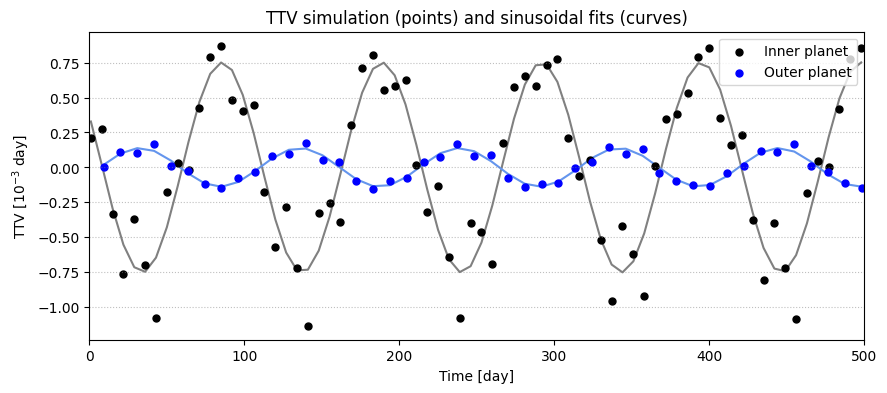

Expected PTTV | validity1 | validity2
105.72231125519362 d | 119.98077495108365 | 114660.8521644585


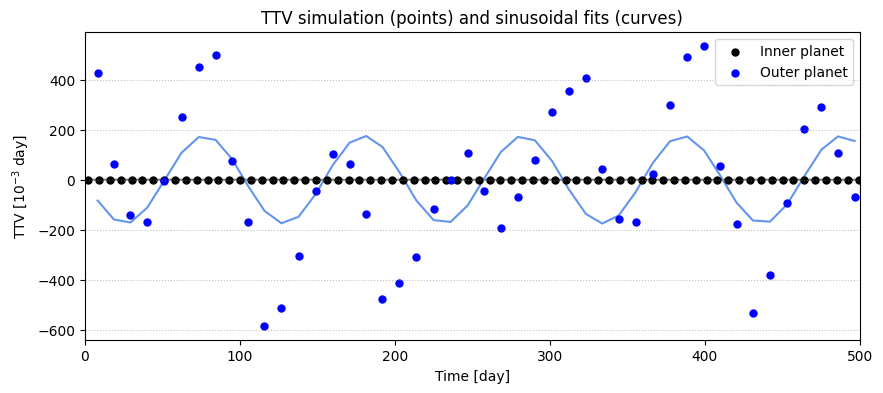

Expected PTTV | validity1 | validity2
65.23770078145434 d | 5086.036643732487 | 181.6022587143169


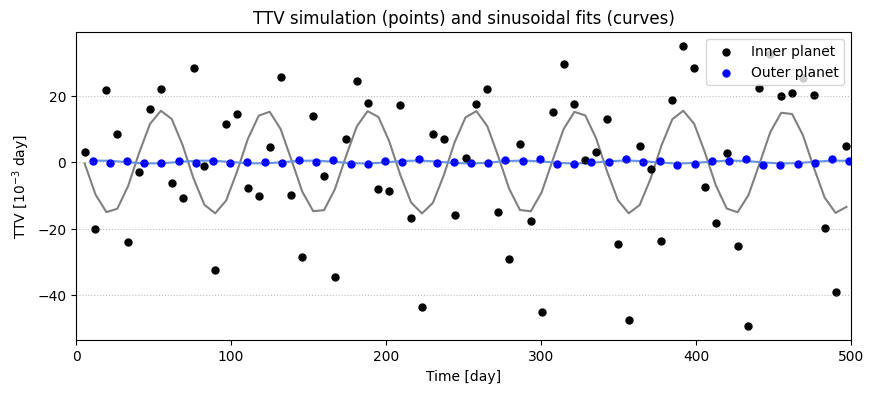

Expected PTTV | validity1 | validity2
37.43839592779783 d | 19598.281331144943 | 1058518.8976232582


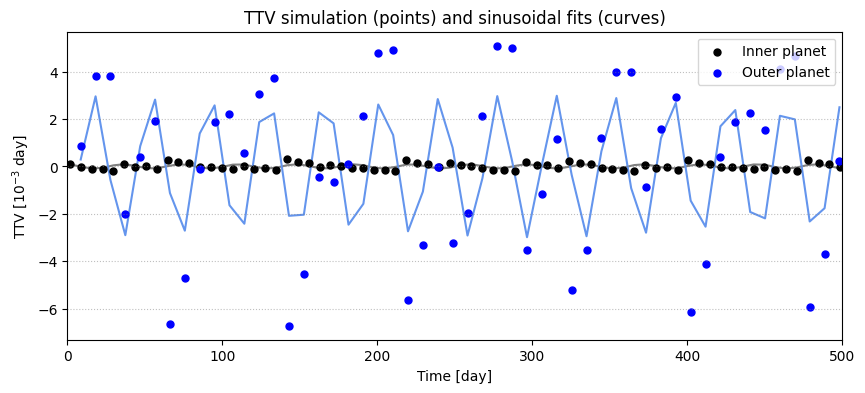

Expected PTTV | validity1 | validity2
156.3106497128593 d | 5970.432189527353 | 3164.364859132639


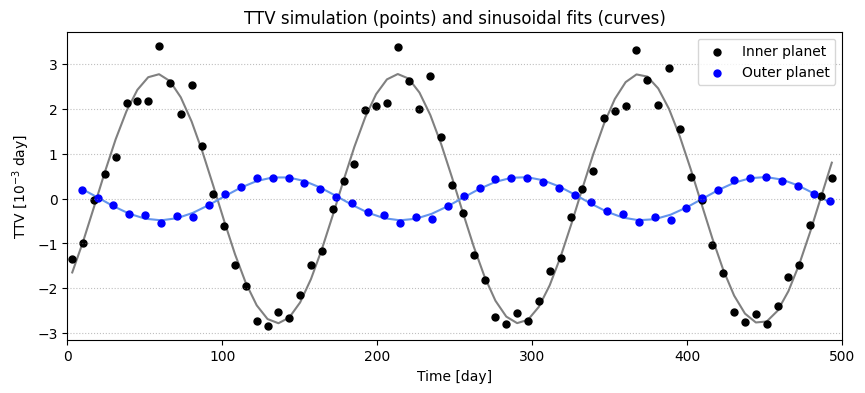

Expected PTTV | validity1 | validity2
45.38821905983719 d | 2326.273318572819 | 168.3675655698324


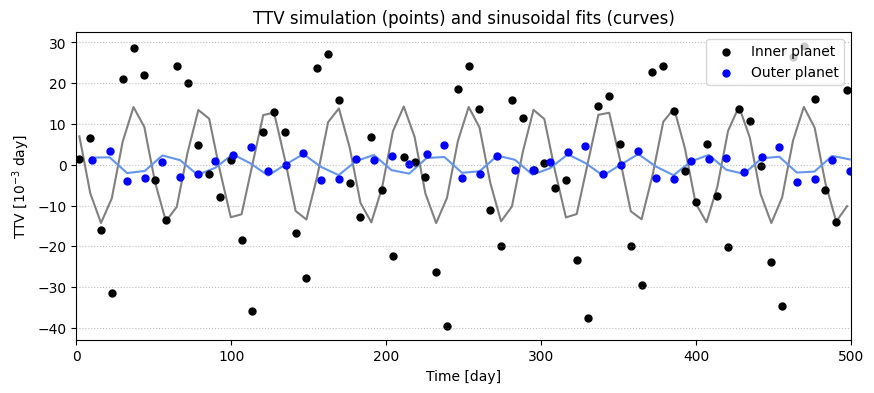

Expected PTTV | validity1 | validity2
83.06442405660508 d | 8375.654698291648 | 91369.4423679655


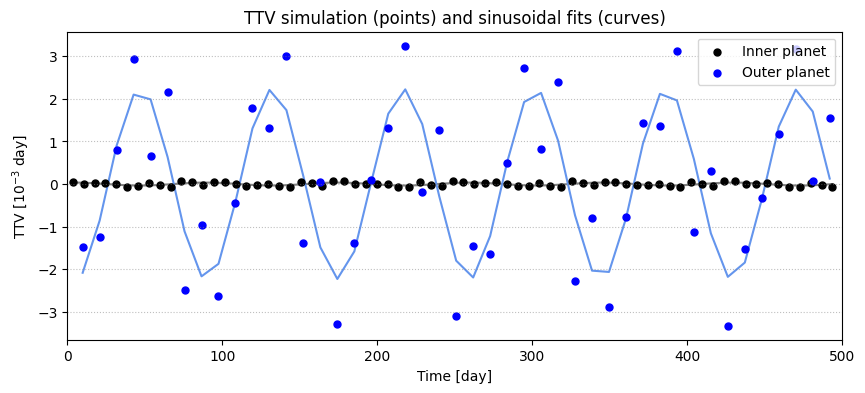

Expected PTTV | validity1 | validity2
162.64529811545526 d | 186.7868819703401 | 242.5697921273276


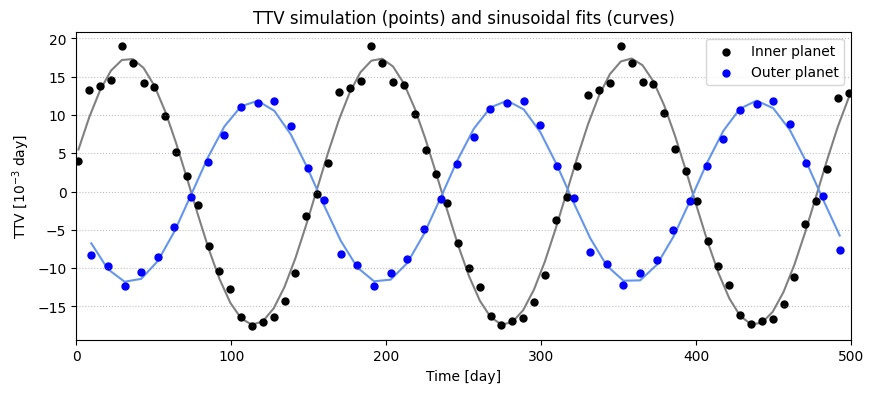

Expected PTTV | validity1 | validity2
120.53527631552271 d | 8638.937871059112 | 402.3306917943797


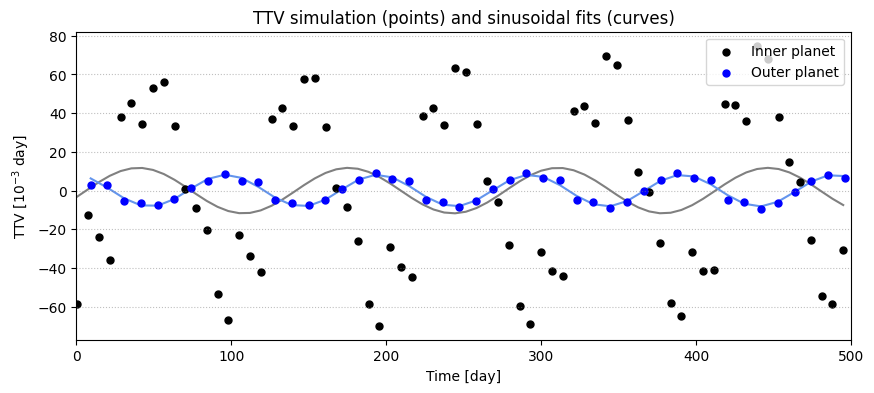

In [45]:
# Create TTV simulations and extract Amplitude and Period
gravity = 0.000295994511 # AU^3/day^2/M_sun
stellar_mass = 1.0       # M_sun

for i, row in df[:15].iterrows():
    # Initialize variables
    P1 = row['P1']; P2 = row['P2']
    j = row['j']
    PTTV = 1/np.abs(j/P2 - (j-1)/P1)
    
    e1 = row['e1']; w1 = row['w1']
    e2 = row['e2']; w2 = row['w2']
    
    mu1 = row['mu1']; mu2 = row['mu2']
    
    # Create TTVFast planets
    planet1 = models.Planet(
        mass=mu1,            # M_sun
        period=P1,           # days
        eccentricity=e1,
        inclination=90,      # degrees
        longnode=0,          # degrees
        argument=90+w1,      # degrees
        mean_anomaly=0       # degrees
    )
    planet2 = models.Planet(
        mass=mu2,
        period=P2,
        eccentricity=e2,
        inclination=90,
        longnode=0,
        argument=90+w2,
        mean_anomaly=0,
    )
    planets = [planet1, planet2]
    
    begin_time = -P2 * 50
    Time = begin_time   # days
    dt = P1 / 100        # days
    Total = max(500, PTTV * 2.5)  # days
    
    results = ttvfast.ttvfast(planets, stellar_mass, Time, dt, Total,
                              input_flag=1)

    # Create TTV signal from TTVFast Output
    out = pd.DataFrame(results['positions']).transpose()
    out.columns = ['planet', 'epoch', 'times', 'rsky', 'vsky']
    
    table0 = out[(out.planet == 0) & (out.times > 0)]
    n0 = table0.epoch
    tn0 = table0.times

    table1 = out[(out.planet == 1) & (out.times > 0)]
    n1 = table1.epoch
    tn1 = table1.times

    if (len(n0) == 0) or (len(n1) == 0):
        continue
    time0, ttv0, ttv0_err = ttvfit.return_ttv(epochs=n0, midtransits=tn0)
    time1, ttv1, ttv1_err = ttvfit.return_ttv(epochs=n1, midtransits=tn1)
    
    # Make sure ttv0 and ttv1 actually are centered around O-C = 0
    ttv0 = ttv0 - (np.max(ttv0) + np.min(ttv0)) / 2
    ttv1 = ttv1 - (np.max(ttv1) + np.min(ttv1)) / 2
    
    # Get sinusoidal TTV model parameters
    popt_ttv0, perr_ttv0, redchi2_0 = ttvfit.characterize_ttv(time=time0, ttv=ttv0, ttv_err=ttv0_err,
                                                              expected_period=PTTV)
    popt_ttv1, perr_ttv1, redchi2_1 = ttvfit.characterize_ttv(time=time1, ttv=ttv1, ttv_err=ttv1_err,
                                                              expected_period=PTTV)
    
    # Plot TTV signal
    print(f'Expected PTTV | validity1 | validity2')
    print(f'{PTTV} d | {row["validity1"]} | {row["validity2"]}')
    
    scaling = 1e+3
    plt.figure(figsize=(10,4))
    plt.scatter(time0, (ttv0 - popt_ttv0[0] - popt_ttv0[1]*time0) * scaling,
                s=25, c='black', label='Inner planet', zorder=1)
    plt.scatter(time1, (ttv1 - popt_ttv1[0] - popt_ttv1[1]*time1) * scaling,
                s=25, c='blue', label='Outer planet', zorder=1)
    plt.plot(time0, ttvfit.ttv_model(time0, 0, 0, *popt_ttv0[2:]) * scaling,
             c='gray', zorder=0)
    plt.plot(time1, ttvfit.ttv_model(time1, 0, 0, *popt_ttv1[2:]) * scaling,
             c='cornflowerblue', zorder=0)
    
    plt.title('TTV simulation (points) and sinusoidal fits (curves)')
    plt.xlabel('Time [day]'); plt.ylabel('TTV [10$^{-3}$ day]')
    plt.xlim(time0.min(), time0.max())
    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle=':', color='gray', alpha=0.5, zorder=-1) # Y-axis lines!
    plt.legend(loc='upper right')

    plt.xlim(0, Total)
    
    plt.show()